<a href="https://colab.research.google.com/github/evlko/CS-224W/blob/main/Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import community
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_style("darkgrid")

sns.set(rc={'figure.figsize':(8, 6)})

# Данные

Скачиваем заранее сохраненные данные и помечаем связи внутри них (относится дружба к 1 / 2 сообществу)

In [2]:
df_friends_connections = pd.read_csv('https://raw.githubusercontent.com/evlko/CS-224W/main/Data/2023_03_15/2023_03_15_friends_connections.csv')
df_friends_connections = df_friends_connections.drop(columns=['Unnamed: 0']).loc[df_friends_connections['community'] == 1]

coms = ['https://raw.githubusercontent.com/evlko/CS-224W/main/Data/2023_03_15/2023_03_15_mathcontent_members-2.csv', 'https://raw.githubusercontent.com/evlko/CS-224W/main/Data/2023_03_15/2023_03_15_publicepsilon777_members.csv']

for i, com in enumerate(coms):
  df_com_members = pd.read_csv(com, index_col=0).rename(columns= {'0':'user_id'})
  df_com_members = set(df_com_members['user_id'].to_list())
  df_friends_connections['com_' + str((i+1))] = df_friends_connections['user_id'].apply(lambda x: 1 if x in df_com_members else 0)

# Метрики
Посчитаем метрики сообществ и сравним их и изученными моделями:
* Случайный граф
* Barabási–Albert model
* Watts–Strogatz model
* Empirical Networks

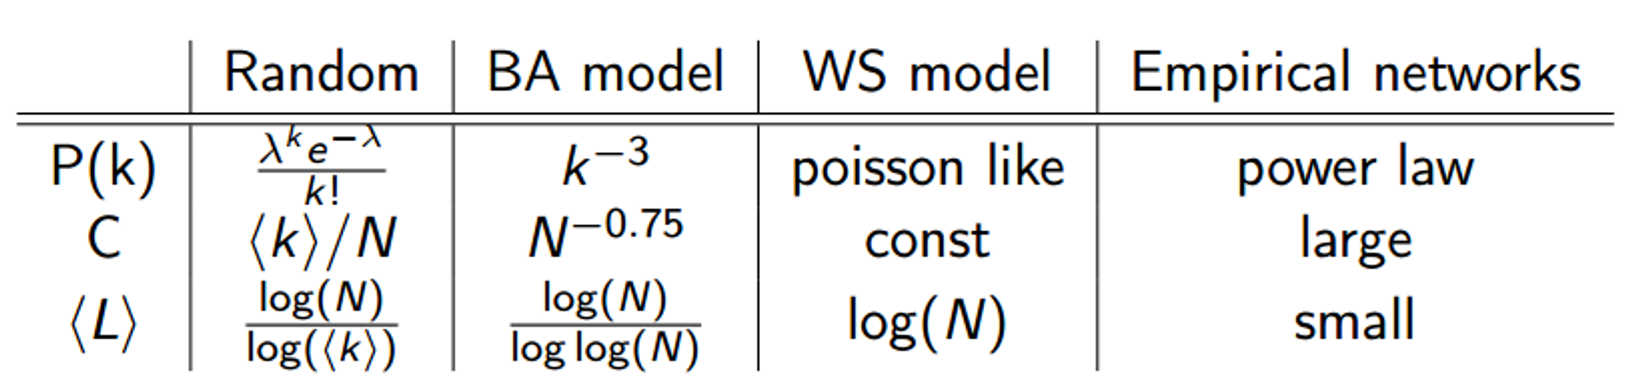

## Функция распределения степеней узлов

In [5]:
dists = []
labels = []
m = 0

# Communities
for i in range(len(coms)):
  df_com = df_friends_connections.loc[df_friends_connections['com_' + str(i+1)] == 1].groupby(by=['user_id']).count().groupby(by=['friends']).count().rename(columns= {'community':'number', 'friends': 'degree'})['number']
  dist = df_com.values
  local_max, local_min = max(dist), min(dist)
  dist = [(i - local_min)/(local_max - local_min) for i in dist]
  dists += [dist]
  labels += ['com_' + str(i+1)]
  m = len(dist) if m < len(dist) else m

# Random
lmbd = 1
dists += [[(lmbd**i * np.exp(-lmbd)) / np.math.factorial(i) for i in range(1, m)]]
labels += ['Random']

# BA Model
dists += [[i**(-3) for i in range(1, m)]]
labels += ['BA Model']

# WS Model
lmbd = 3
dists += [[(lmbd**i * np.exp(-lmbd)) / np.math.factorial(i) for i in range(1, m)]]
labels += ['WS Model']

# Empirical Nets
a = 0.67
dists += [[a*i**(a-1) for i in range(1, m)]]
labels += ['Empirical Nets']

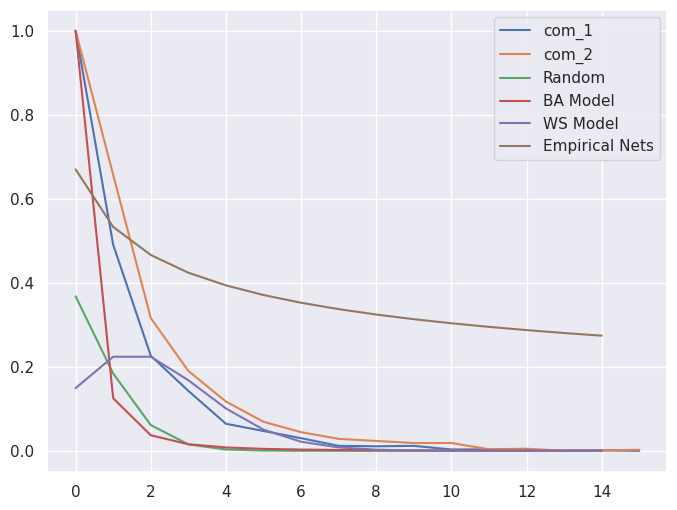

In [6]:
sns.lineplot(data=dists, legend=False, dashes=False, ci=None)

plt.legend(labels=labels)

Как видно из графиков, сообщества ближе всего к модели Барабаши — Альберта

## Средняя длина пути
Для простоты расчетов воспользуемся библиотекой `networkx`, поэтому переведем наш `dataframe` в `graph`

In [7]:
graphs=[]
for i in range(len(coms)):
  df_com = df_friends_connections.loc[df_friends_connections['com_' + str(i+1)] == 1]
  G=nx.from_pandas_edgelist(df_com, source='user_id', target='friends')
  G=G.to_directed()
  graphs.append(G)

In [8]:
paths_df = pd.DataFrame(columns=['Community', 'Random', 'BA Model', 'WS Model'])
for g in graphs:
  strong_g = g.subgraph(max(nx.strongly_connected_components(g), key=len))
  path = nx.average_shortest_path_length(strong_g)
  n = nx.number_of_nodes(g)
  avg_k = np.mean([g.degree[i] for i in g.nodes()])
  com = {
     'Community': path,
     'Random': np.log2(n) / np.log2(avg_k),
     'BA Model': np.log2(n) / np.log2(np.log2(n)),
     'WS Model': np.log2(n)
  }
  paths_df.loc[len(paths_df)] = com
paths_df

,Community,Random,BA Model,WS Model
0,10.107428,5.908422,3.290535,11.659996
1,9.531903,5.456030,3.299034,11.710806


Теперь же сообщества ближе к модели Уоттса-Строгаца!

## Кластерные коэффициенты

In [9]:
cluster_coef_df = pd.DataFrame(columns=['Community', 'Random', 'BA Model', 'WS Model'])
for g in graphs:
  path = nx.average_clustering(g)
  n = nx.number_of_nodes(g)
  avg_k = np.mean([g.degree[i] for i in g.nodes()])
  com = {
     'Community': path,
     'Random': avg_k / n,
     'BA Model': n**(-0.75),
     'WS Model': (3*(avg_k-2)) / (4*(avg_k-1))
  }
  cluster_coef_df.loc[len(cluster_coef_df)] = com
cluster_coef_df

,Community,Random,BA Model,WS Model
0,0.076292,0.001214,0.002331,0.493771
1,0.089847,0.001321,0.002270,0.531163


Тут же сообщетсва достаточно далеки от всех моделей. Даже `Empirical Nets` не подходят, так как они принимают, скажем так, *large values* при кластеризации и *small* в путях. Тут же мы видим несколько обратную картину.